In [1]:
%run "../../shared/utilz_includez.ipynb"

In [2]:
from skimage import io, img_as_float, img_as_ubyte
from skimage import color , measure

from scipy import ndimage as nd

import cv2 

In [3]:
def plot_image( img_array , plotit=True, title=None, cmapd='gray'):     
    print( f"\n{ '-'*7 } { title if title else type(img_array) } { '-'*7 }" )
    print( f"image.shape = {img_array.shape}" ) 
    print( f"datatype = {img_array.dtype}")
    print( f"min = {np.min(img_array)} , max = {np.max(img_array)}\n" )
    if plotit:
        if cmapd:
            plt.imshow( img_array , cmap=cmapd)
        else:
            plt.imshow( img_array )
    if title:
        plt.title(title)
        

# 1. Grain Size Analysis using OTSU Binary Segmentation

- Microstructure analysis
- 


------- Original Grain Image -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- Grayscale Grain Image -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255



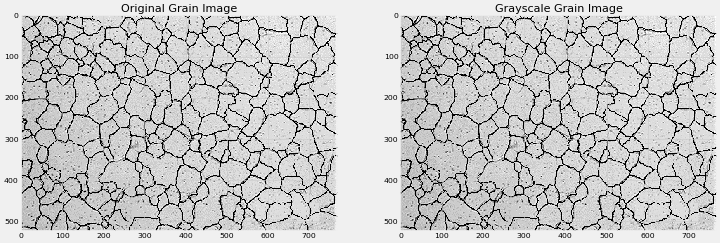

In [4]:
ip = "https://4.bp.blogspot.com/_6sy6DITvP_s/TKbdzLMBH5I/AAAAAAAABmw/1M8z5xwIcno/s1600/505h.JPG"
img = io.imread( ip )
gimg = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY)

## crop image to remove scale bar if at all. E.G.
#img = img[0:300, :, :]

nr, nc = 1, 2

plt.subplot(nr, nc, 1)
plot_image(img, title = 'Original Grain Image')

plt.subplot(nr, nc, 2)
plot_image( gimg, title = 'Grayscale Grain Image'); 

In [5]:
## 1. Define pixel size relative microscope 
pixels_to_um = 0.5 

radianz = 57.2958

In [6]:
## 2. Denoise 
# a. medium or Non-Local-Means, which is great for micrscope images
# b. clean up @ erode, 

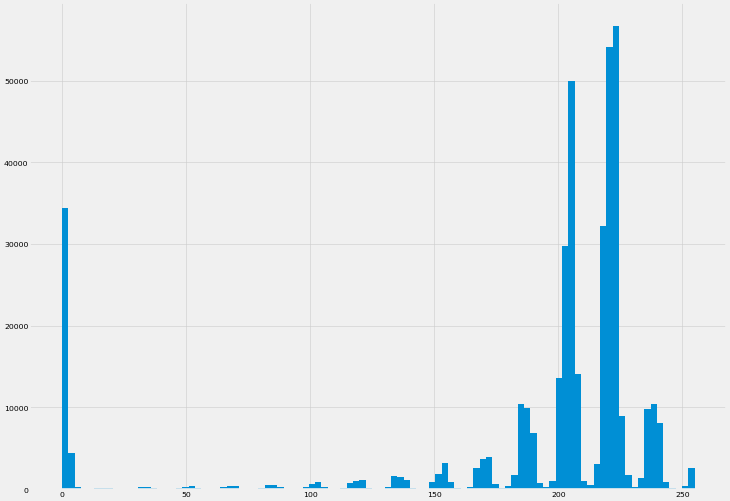

In [7]:
## 3. Threshold it
# 3.a. look at histogram

plt.hist(gimg.flat, bins=100, range=(0, 255)); 

OTSU threshold = 109.0

------- OTSU thresholded Image -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255



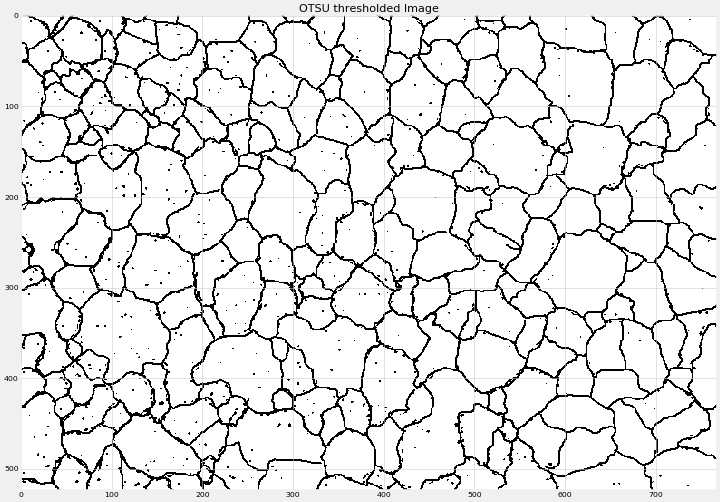

In [8]:
# 3.b. Threshold it
# can do manual or auto with OTSU at binary
otsu, timg = cv2.threshold(gimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print( f"OTSU threshold = {otsu}" )
plot_image( timg, title='OTSU thresholded Image'); 


------- Eroded & Dilated Image -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255


------- Resulting Binary Image -------
image.shape = (524, 768)
datatype = bool
min = False , max = True



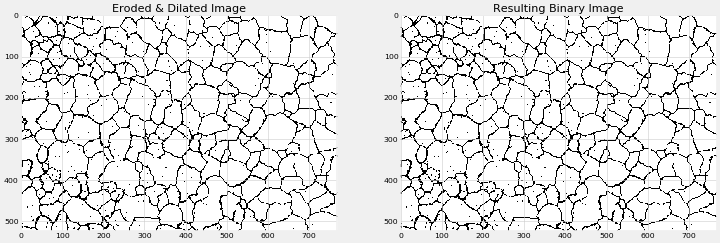

In [9]:
# 3.c. Erode and dilate to make better definition of the grains
kern = np.ones( (3,3), dtype=np.uint8 )
timg = cv2.erode( timg, kern, iterations=1)
timg = cv2.dilate( timg, kern, iterations=1)

# 3.d. convert to binary image
mask = timg == 255


nr, nc = 1, 2

plt.subplot(nr, nc, 1)
plot_image( timg, title='Eroded & Dilated Image'); 

plt.subplot(nr, nc, 2)
plot_image( mask, title='Resulting Binary Image'); 

Structure factor: 
 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

 Number of labels = 242

------- Labeled Image -------
image.shape = (524, 768)
datatype = int32
min = 0 , max = 242


------- Labeled Image @ Color -------
image.shape = (524, 768, 3)
datatype = float64
min = 0.0 , max = 1.0



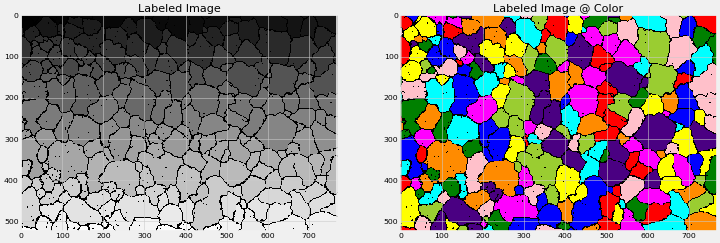

In [10]:
## 4. Label the grains in the binary image 
struct_factor = np.ones((3,3)) # check doc @ when to consider a pixel to be connected to another
print( "Structure factor: \n", struct_factor)

# In ndimage, there's a label function that labels each unconnected grain/object
label_mask, n_mask = nd.label( mask, structure=struct_factor)
print( f"\n Number of labels = {n_mask}")

# # effect on thresholded image only @ curious
# _, oi = cv2.threshold(gimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# otsu_label, on_mask = nd.label( oi == 255, structure=struct_factor)

nr,nc = 2, 2

plt.subplot( nr, nc, 1)
plot_image( label_mask, title='Labeled Image'); 

plt.subplot( nr, nc, 2)
plot_image( color.label2rgb(label_mask, bg_label=0), title='Labeled Image @ Color'); 


# plt.subplot( nr, nc, 3)
# plot_image( otsu_label, title='OTSU only Labeled Image'); 

# plt.subplot( nr, nc, 4)
# plot_image( color.label2rgb(otsu_label, bg_label=0), title='OTSU only Labeled Image @ Color'); 



In [11]:
## 5. Measure the properties of each grain
# a. skimage regionprop methods, extracts a bunch of region properties of a label image
#    e.g. area, equivalent diameter, etc << obj type RegionProperties
#         will calc intesity relative to original image if it is provided 


clusterz = measure.regionprops(label_mask, gimg)
print( f"Region Properties: \n{type(clusterz)}, len = {len(clusterz)}, x type = {type(clusterz[0])} \nE.G: {clusterz[0]}")
g = clusterz[0]
propz = ['Label', "Area", "Perimeter", 
         "equivalent_diameter", "orientation",
        "MajorAxisLength", "MinorAxisLength",
         "MinIntensity", "MaxIntensity", "MeanIntensity",
        ]
addz = ["Area_nm", "Perimeter_nm", 
         "equivalent_diameter_nm", 
        "orientation_degrees",
        "MajorAxisLength_nm", "MinorAxisLength_nm",]
for p in propz:
    print( f"\t{p}: \t\t{g[p]}" )
    
## Create dframe for it
dd = []
for g in clusterz:
    gl = []
    for p in propz:
        gl.append( g[p] )
    
    for ap in addz:
        p = "_".join( ap.split("_")[:-1])
        
        ## Area_nm
        if( p == 'Area'):
            gl.append( g[p] * pixels_to_um**2 )
        ## Orientation_nm
        elif( p == 'orientation'):
            gl.append( g[p]* radianz ) 
        ## anything that's not Intensity
        else:
            gl.append( g[p]* pixels_to_um ) 
            
        
    dd.append( gl )
    
    
    
df = pd.DataFrame.from_records( dd , columns=propz+addz )
df.head(3)

Region Properties: 
<class 'list'>, len = 242, x type = <class 'skimage.measure._regionprops.RegionProperties'> 
E.G: <skimage.measure._regionprops.RegionProperties object at 0x7fab812ee110>
	Label: 		1
	Area: 		740
	Perimeter: 		120.87615433949868
	equivalent_diameter: 		30.695231927842155
	orientation: 		0.5862106050014976
	MajorAxisLength: 		34.49447908163162
	MinorAxisLength: 		29.16688261449742
	MinIntensity: 		115
	MaxIntensity: 		255
	MeanIntensity: 		202.98108108108107


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
0,1,740,120.876154,30.695232,0.586211,34.494479,29.166883,115,255,202.981081,185.0,60.438077,15.347616,33.587406,17.247240,14.583441
1,2,254,79.870058,17.983405,1.371669,28.564593,15.388591,117,255,205.846457,63.5,39.935029,8.991702,78.590857,14.282297,7.694296
2,3,94,49.284271,10.940042,-0.652965,22.396837,5.506042,116,255,212.819149,23.5,24.642136,5.470021,-37.412178,11.198419,2.753021


In [12]:
## summary stats
np.round(df.describe(), 1)

,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
count,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0
mean,121.5,1461.5,170.6,39.0,0.1,51.6,32.8,116.9,253.4,208.4,365.4,85.3,19.5,4.5,25.8,16.4
std,70.0,1278.7,91.9,18.4,0.9,24.0,16.8,6.4,5.4,9.0,319.7,46.0,9.2,52.5,12.0,8.4
min,1.0,12.0,10.0,3.9,-1.6,4.5,2.9,111.0,208.0,168.9,3.0,5.0,2.0,-89.9,2.2,1.4
25%,61.2,490.2,101.8,25.0,-0.6,32.9,21.0,115.0,255.0,202.9,122.6,50.9,12.5,-32.6,16.4,10.5
50%,121.5,1248.5,168.9,39.9,0.1,50.1,32.7,116.0,255.0,209.3,312.1,84.5,19.9,5.9,25.1,16.4
75%,181.8,2011.8,218.7,50.6,0.9,67.8,42.1,117.0,255.0,215.2,502.9,109.3,25.3,50.4,33.9,21.0
max,242.0,6657.0,548.6,92.1,1.6,150.5,87.4,167.0,255.0,229.8,1664.2,274.3,46.0,90.0,75.3,43.7


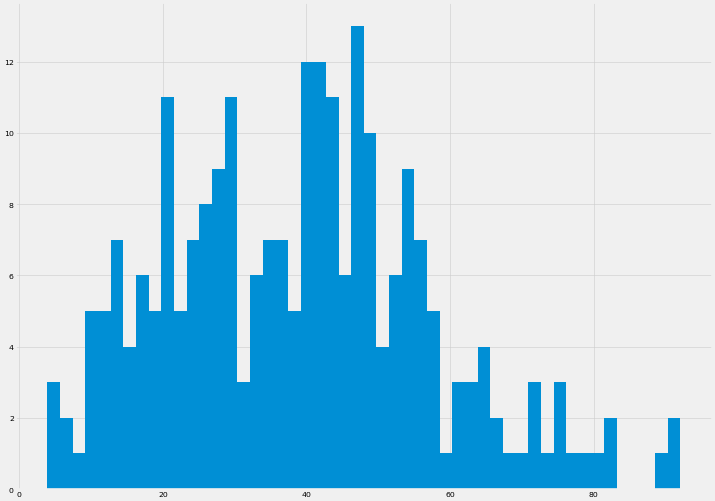

In [13]:
#plt.scatter(df.Label, df.Area); 
plt.hist( df.equivalent_diameter, bins=50); 

# 2. Grain Size Analysis using Watershed Segmentation
- **Watershed Segmentation**


------- Orignal Image -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- Clean Morphological.Open -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255


------- Sure Background -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255


------- Distance Transform Image -------
image.shape = (524, 768)
datatype = float32
min = 0.0 , max = 39.709503173828125


------- Sure Foreground -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255


------- Unkown pixels -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255



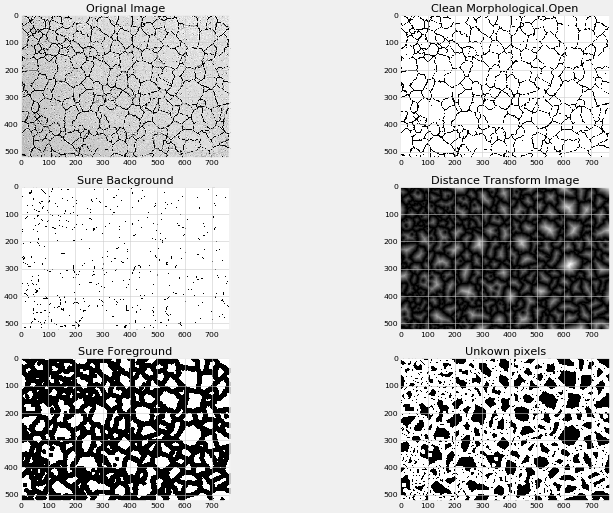

In [14]:
## A. Define markers for watershed thresholding 
# recall: timg = OTSU threshold and erode + dilate to clean to timg 
# recall: kern = np.ones(3,3, uint8)

# 1.
mimg = timg.copy()
# paranoid redo:
# kern = np.ones( (3,3), np.uint8)
# _, mimg = cv2.threshold(gimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU )
mimg = cv2.medianBlur(mimg, 3)
mimg = cv2.morphologyEx( mimg, cv2.MORPH_OPEN, kern, iterations=1)


# 2. Identify sure background and foreground pixels as extra on
sure_bg = cv2.dilate( mimg, kern, iterations=1)

dimg = cv2.distanceTransform( mimg, cv2.DIST_L2, 3)


# 3. Threshold
tval = 0.2
_, sure_fg = cv2.threshold(dimg, tval*dimg.max(),  255, 0)
sure_fg = np.uint8( sure_fg )

unknownz = cv2.subtract( sure_bg, sure_fg)



nr,nc = 3, 2

plt.subplot( nr, nc, 1)
plot_image(img, title='Orignal Image'); 

plt.subplot( nr, nc, 2)
plot_image( mimg, title='Clean Morphological.Open');


plt.subplot( nr, nc, 3)
plot_image( sure_bg, title='Sure Background');

plt.subplot( nr, nc, 4)
plot_image( dimg, title='Distance Transform Image'); 

plt.subplot( nr, nc, 5)
plot_image( sure_fg, title='Sure Foreground');

plt.subplot( nr, nc, 6)
plot_image( unknownz, title="Unkown pixels" );




------- markers via connected components -------
image.shape = (524, 768)
datatype = int32
min = 0 , max = 233



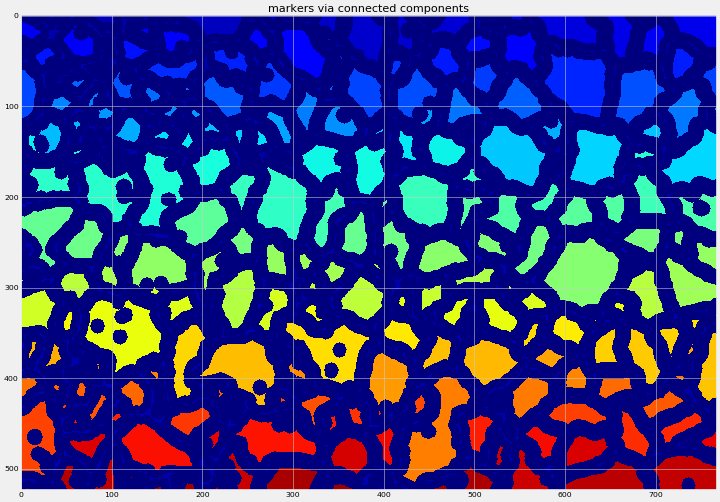

In [15]:
# 4. Define Markers using Connected Components 
# joins porous boundaries to create one entity

_, markers = cv2.connectedComponents( sure_fg )

# by default markers is setup with zeros and so the background is also zeros and gets mixed up with unkwons<< anything other than the sure_fg is left at zero
# so to distinguish them add some value 
# print( markers.shape )
markers = markers+10
markers[ unknownz == 255 ] = 0 

plot_image( markers, title="markers via connected components", cmapd='jet')


------- original image -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- watershed image -------
image.shape = (524, 768)
datatype = int32
min = -1 , max = 232



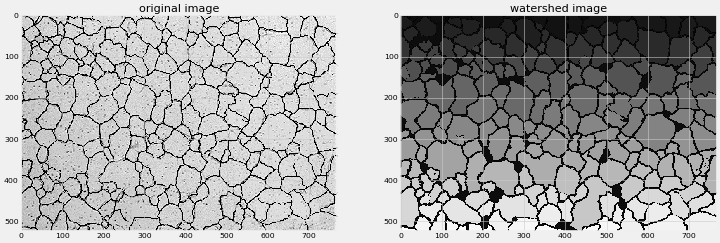

In [16]:
## 4.b. now do watershed
watershed = cv2.watershed( img, markers )

nr, nc = 1, 2

plt.subplot(nr, nc, 1)
plot_image( img, title="original image")

plt.subplot(nr, nc, 2)
plot_image( watershed, title="watershed image"); 


------- Ready image -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- Labels to RGB -------
image.shape = (524, 768, 3)
datatype = float64
min = 0.0 , max = 1.0



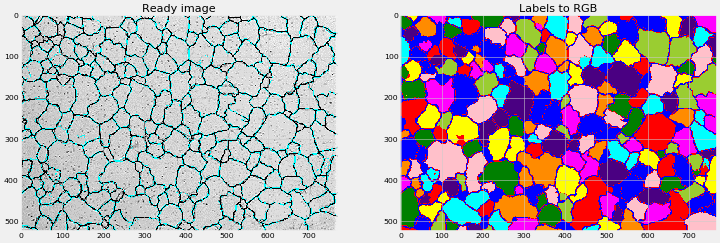

In [17]:
ready_img = img.copy()
ready_img[ markers == -1] = [0, 255, 255]
rimg2 = color.label2rgb( markers, bg_label=0 )


nr, nc = 1, 2

plt.subplot(nr, nc, 1)
plot_image( ready_img, title="Ready image")

plt.subplot(nr, nc, 2)
plot_image( rimg2, title="Labels to RGB"); 

---
#### Remove border cells b/c partial sizes and see what results look like



------- Ready image -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- Bila Border Cells - Labels to RGB -------
image.shape = (524, 768, 3)
datatype = float64
min = 0.0 , max = 1.0



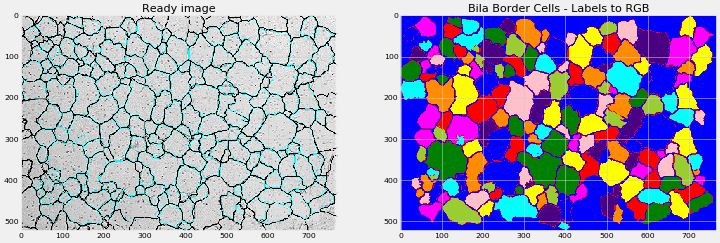

In [18]:
###### 7. Grains at the perimeter will be partial. So let's remove them
from skimage.segmentation import clear_border

# 1.
mimg = timg.copy()
# paranoid redo:
# kern = np.ones( (3,3), np.uint8)
# _, mimg = cv2.threshold(gimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU )
mimg = cv2.medianBlur(mimg, 3)
mimg = cv2.morphologyEx( mimg, cv2.MORPH_OPEN, kern, iterations=1)

## clear border cells/grains at this point 
mimg = clear_border( mimg )


# 2. Identify sure background and foreground pixels as extra on
sure_bg = cv2.dilate( mimg, kern, iterations=1)
dimg = cv2.distanceTransform( mimg, cv2.DIST_L2, 3)

# 3. Threshold
tval = 0.2
_, sure_fg = cv2.threshold(dimg, tval*dimg.max(),  255, 0)
sure_fg = np.uint8( sure_fg )
unknownz = cv2.subtract( sure_bg, sure_fg)

# 4. Define Markers using Connected Components 
# joins porous boundaries to create one entity
_, markers = cv2.connectedComponents( sure_fg )

# by default markers is setup with zeros and so the background is also zeros and gets mixed up with unkwons<< anything other than the sure_fg is left at zero
# so to distinguish them add some value 
# print( markers.shape )
markers = markers+10
markers[ unknownz == 255 ] = 0 

## 4.b. now do watershed
watershed = cv2.watershed( img, markers )

ready_img = img.copy()
ready_img[ markers == -1] = [0, 255, 255]
rimg2 = color.label2rgb( markers, bg_label=0 )



nr, nc = 1, 2

plt.subplot(nr, nc, 1)
plot_image( ready_img, title="Ready image")

plt.subplot(nr, nc, 2)
plot_image( rimg2, title="Bila Border Cells - Labels to RGB"); 

---
### Now do Region Properties

In [19]:
## 5. Measure the properties of each grain
# a. skimage regionprop methods, extracts a bunch of region properties of a label image
#    e.g. area, equivalent diameter, etc << obj type RegionProperties
#         will calc intesity relative to original image if it is provided 


clusterz = measure.regionprops(markers, intensity_image=gimg)
print( f"Region Properties: \n{type(clusterz)}, len = {len(clusterz)}, x type = {type(clusterz[0])} \nE.G: {clusterz[0]}")
g = clusterz[0]
propz = ['Label', "Area", "Perimeter", 
         "equivalent_diameter", "orientation",
        "MajorAxisLength", "MinorAxisLength",
         "MinIntensity", "MaxIntensity", "MeanIntensity",
        ]
addz = ["Area_nm", "Perimeter_nm", 
         "equivalent_diameter_nm", 
        "orientation_degrees",
        "MajorAxisLength_nm", "MinorAxisLength_nm",]
for p in propz:
    print( f"\t{p}: \t\t{g[p]}" )
    
## Create dframe for it
dd = []
for g in clusterz:
    gl = []
    for p in propz:
        gl.append( g[p] )
    
    for ap in addz:
        p = "_".join( ap.split("_")[:-1])
        
        ## Area_nm
        if( p == 'Area'):
            gl.append( g[p] * pixels_to_um**2 )
        ## Orientation_nm
        elif( p == 'orientation'):
            gl.append( g[p]* radianz ) 
        ## anything that's not Intensity
        else:
            gl.append( g[p]* pixels_to_um ) 
            
        
    dd.append( gl )
    
    
    
df2 = pd.DataFrame.from_records( dd , columns=propz+addz )
df2.head(3)

Region Properties: 
<class 'list'>, len = 177, x type = <class 'skimage.measure._regionprops.RegionProperties'> 
E.G: <skimage.measure._regionprops.RegionProperties object at 0x7fab740c3f50>
	Label: 		10
	Area: 		117728
	Perimeter: 		25122.60240488124
	equivalent_diameter: 		387.163977046653
	orientation: 		-1.5345734286401895
	MajorAxisLength: 		1032.8987002400645
	MinorAxisLength: 		717.9994576522097
	MinIntensity: 		0
	MaxIntensity: 		255
	MeanIntensity: 		135.2684153302528


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
0,10,117728,25122.602405,387.163977,-1.534573,1032.898700,717.999458,0,255,135.268415,29432.00,12561.301202,193.581989,-87.924612,516.449350,358.999729
1,11,1341,160.610173,41.320869,-0.334404,50.704861,35.497372,82,255,219.006711,335.25,80.305087,20.660435,-19.159929,25.352431,17.748686
2,12,1620,162.852814,45.416385,0.867038,50.929979,41.260870,19,255,208.117284,405.00,81.426407,22.708193,49.677618,25.464989,20.630435


In [24]:
print( "## 1. Watershed results" )
np.round(df2.describe(), 1)

## Watershed results


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
count,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0
mean,98.0,2125.2,298.2,41.7,0.0,55.8,37.8,65.4,252.5,209.6,531.3,149.1,20.8,1.0,27.9,18.9
std,51.2,8821.2,1877.8,31.2,0.9,76.9,53.7,51.8,8.3,9.3,2205.3,938.9,15.6,50.9,38.5,26.9
min,10.0,1.0,0.0,1.1,-1.6,0.0,0.0,0.0,204.0,135.3,0.2,0.0,0.6,-89.6,0.0,0.0
25%,54.0,553.0,105.3,26.5,-0.7,35.3,21.6,17.0,255.0,205.7,138.2,52.6,13.3,-40.7,17.6,10.8
50%,98.0,1232.0,153.3,39.6,0.0,50.2,33.5,67.0,255.0,210.9,308.0,76.7,19.8,0.7,25.1,16.7
75%,142.0,1979.0,199.2,50.2,0.8,65.3,41.7,100.0,255.0,216.1,494.8,99.6,25.1,45.0,32.7,20.9
max,186.0,117728.0,25122.6,387.2,1.6,1032.9,718.0,209.0,255.0,222.3,29432.0,12561.3,193.6,89.7,516.4,359.0


In [26]:
print( "## 2. Compare other method" )
np.round(df.describe(), 1)

## 2. Compare other method


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
count,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0
mean,121.5,1461.5,170.6,39.0,0.1,51.6,32.8,116.9,253.4,208.4,365.4,85.3,19.5,4.5,25.8,16.4
std,70.0,1278.7,91.9,18.4,0.9,24.0,16.8,6.4,5.4,9.0,319.7,46.0,9.2,52.5,12.0,8.4
min,1.0,12.0,10.0,3.9,-1.6,4.5,2.9,111.0,208.0,168.9,3.0,5.0,2.0,-89.9,2.2,1.4
25%,61.2,490.2,101.8,25.0,-0.6,32.9,21.0,115.0,255.0,202.9,122.6,50.9,12.5,-32.6,16.4,10.5
50%,121.5,1248.5,168.9,39.9,0.1,50.1,32.7,116.0,255.0,209.3,312.1,84.5,19.9,5.9,25.1,16.4
75%,181.8,2011.8,218.7,50.6,0.9,67.8,42.1,117.0,255.0,215.2,502.9,109.3,25.3,50.4,33.9,21.0
max,242.0,6657.0,548.6,92.1,1.6,150.5,87.4,167.0,255.0,229.8,1664.2,274.3,46.0,90.0,75.3,43.7
